In [103]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats

In [104]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_daq as daq
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

In [105]:
df = pd.read_csv('../data/margin_data.csv')
df['Width'] = df['Width'].apply(str)
df['Height'] = df['Height'].apply(str)

In [106]:
descriptors = df.columns[:-3]

In [107]:
delimiters = df.columns[:-3]
moodsdf = pd.DataFrame()
pop = list(df['EBITDA'])
# pop = np.random.choice(pop, size=int(1e5))
for delimiter in delimiters:
    grouped = df.groupby(delimiter)['EBITDA']
    group_with_values = grouped.apply(list)

    # bootstrap population of values based on groups
#     pop = np.random.choice((np.concatenate(group_with_values)), 
#                            size=int(1e4))
    
    for index, group in enumerate(group_with_values):
        stat, p, m, table = scipy.stats.median_test(group, pop)
        median = np.median(group)
        mean = np.mean(group)
        size = len(group)
        moodsdf = pd.concat([moodsdf, 
                                 pd.DataFrame([delimiter, group_with_values.index[index],
                                              stat, p, m, mean, median, size, table]).T])
moodsdf.columns = ['descriptor', 'group', 'pearsons_chi_square', 'p_value', 'grand_median', 'group_mean',
                   'group_median', 'size', 'table']


In [108]:
moodsdf = moodsdf.loc[moodsdf['p_value'] < 1e-3]
moodsdf = moodsdf.sort_values('group_median').reset_index(drop=True)

In [109]:
def make_violin_plot(sort='Worst', select=[0,5], descriptors=None):

    if sort == 'Best':
        local_df = moodsdf.sort_values('group_median', ascending=False)
        local_df = local_df.reset_index(drop=True)
    else:
        local_df = moodsdf
    if descriptors != None:
        local_df = local_df.loc[local_df['descriptor'].isin(descriptors)]
    fig = go.Figure()
    for index in range(select[0],select[1]):
        x = df.loc[(df[local_df.iloc[index]['descriptor']] == \
            local_df.iloc[index]['group'])]['EBITDA']
        y = local_df.iloc[index]['descriptor'] + ': ' + df.loc[(df[local_df\
            .iloc[index]['descriptor']] == local_df.iloc[index]['group'])]\
            [local_df.iloc[index]['descriptor']]
        name = '€ {:.0f}'.format(x.median())
        fig.add_trace(go.Violin(x=y,
                                y=x,
                                name=name,
                                box_visible=True,
                                meanline_visible=True))
    fig.update_layout({
                "plot_bgcolor": "#FFFFFF",
                "paper_bgcolor": "#FFFFFF",
                "title": 'EBITDA by Product Descriptor (Median in Legend)',
                "yaxis.title": "EBITDA (€)",
                "height": 325,
                "font": dict(
                            size=10),
                "margin": dict(
                       l=0,
                       r=0,
                       b=0,
                       t=30,
                       pad=4
   ),
                })

    return fig

def make_sunburst_plot(clickData=None, toAdd=None, col=None, val=None):
    if clickData != None:
        col = clickData["points"][0]['x'].split(": ")[0]
        val = clickData["points"][0]['x'].split(": ")[1]
    elif col == None:
        col = moodsdf.iloc[-1]['descriptor']
        val = moodsdf.iloc[-1]['group']

    desc = list(descriptors[:-2])
    if col in desc:
        desc.remove(col)
    if toAdd != None:
        for item in toAdd:
            desc.append(item)
    test = df.loc[df[col] == val]
    fig = px.sunburst(test, path=desc[:], color='EBITDA', title='{}: {}'.format(
        col, val),
        color_continuous_scale=px.colors.sequential.Viridis
                     )
    fig.update_layout({
                "plot_bgcolor": "#FFFFFF",
                "title": '(Select in Violin) {}: {}'.format(col,val),
                "paper_bgcolor": "#FFFFFF",
                "height": 325,
                "font": dict(
                    size=10),
                "margin": dict(
                       l=0,
                       r=0,
                       b=0,
                       t=30,
                       pad=4
   ),
                })
    return fig

def make_ebit_plot(df, select=None, sort='Worst', descriptors=None):
    families = df[df.columns[0]].unique()
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3',\
              '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
    colors_cycle = cycle(colors)
    
    color_dic = {'{}'.format(i): '{}'.format(j) for i, j  in zip(families,
                                                                 colors)}
    
    fig = go.Figure()


    if select == None:
        for data in px.scatter(
                df,
                x='Product',
                y='EBITDA',
                color=df.columns[0],
                color_discrete_map=color_dic,
                opacity=1).data:
            fig.add_trace(
                data
            )

    elif select != None:
        color_dic = {'{}'.format(i): '{}'.format(j) for i, j  in zip(select,
                                                                     colors)}
        for data in px.scatter(
                df,
                x='Product',
                y='EBITDA',
                color=df.columns[0],

                color_discrete_map=color_dic,
                opacity=0.09).data:
            fig.add_trace(
                data
            )

        if sort == 'Best':
            local_df = moodsdf.sort_values('group_median', ascending=False)
        elif sort == 'Worst':
            local_df = moodsdf
            


        new_df = pd.DataFrame()
        if descriptors != None:
            local_df = local_df.loc[local_df['descriptor'].isin(descriptors)]
        for index in select:
            x = df.loc[(df[local_df.iloc[index]\
                ['descriptor']] == local_df.iloc[index]['group'])]
            x['color'] = next(colors_cycle) # for line shapes
            new_df = pd.concat([new_df, x])
            new_df = new_df.reset_index(drop=True)
#         for data in px.scatter(
#                 new_df,
#                 x='Product',
#                 y='EBITDA',
#                 color=df.columns[0],

#                 color_discrete_map=color_dic,
#                 opacity=1).data:
#             fig.add_trace(
#                 data
#             )
        shapes=[]

        for index, i in enumerate(new_df['Product']):
            shapes.append({'type': 'line',
                           'xref': 'x',
                           'yref': 'y',
                           'x0': i,
                           'y0': -4e5,
                           'x1': i,
                           'y1': 4e5,
                           'line':dict(
                               dash="dot",
                               color=new_df['color'][index],)})
        fig.update_layout(shapes=shapes)
    fig.update_layout({
            "plot_bgcolor": "#FFFFFF",
            "paper_bgcolor": "#FFFFFF",
            "title": 'Rank Order EBITDA by {}'.format(df.columns[0]),
            "yaxis.title": "EBITDA (€)",
            "height": 325,
            "font": dict(
                        size=10),
            "margin": dict(
                   l=0,
                   r=0,
                   b=0,
                   t=30,
                   pad=4
),
            "xaxis.tickfont.size": 8,
            })
    return fig

In [110]:
# Build App
external_stylesheets = ['../assets/styles.css', '../assets/s1.css', 'https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div([
    html.Div([
        html.Div([
            html.P('Descriptors'),
            dcc.Dropdown(id='descriptor_dropdown',
                         options=[{'label': i, 'value': i} for i in descriptors],
                         value=descriptors,
                         multi=True,
                         className="dcc_control"),
            html.P('Number of Descriptors:', id='descriptor-number'),
            dcc.RangeSlider(
                        id='select',
                        min=0,
                        max=moodsdf.shape[0],
                        step=1,
                        value=[0,10]),
            html.P('Sort by:'),
            dcc.RadioItems(
                        id='sort',
                        options=[{'label': i, 'value': j} for i, j in \
                                [['Low EBITDA', 'Worst'],
                                ['High EBITDA', 'Best']]],
                        value='Best',
                        labelStyle={'display': 'inline-block'},
                        style={"margin-bottom": "10px"},),
            html.P('Toggle view Violin/Descriptor Data'),
            daq.BooleanSwitch(
                  id='daq-violin',
                  on=False,
                  style={"margin-bottom": "10px", "margin-left": "0px",
                  'display': 'inline-block'}),
            
        ],  
        className='mini_container',
        id='descriptorBlock',
        style={'width': '32%', 'display': 'inline-block'}
        ),     
        html.Div([
            dcc.Graph(
                        id='ebit_plot',
                        figure=make_ebit_plot(df)),
        ], 
        className='mini_container',
        style={'width': '65%', 'float': 'right', 'display': 'inline-block'},
        id='ebit-family-block'
        ),

    ], className='row container-display',
       
    ),

    html.Div([
        html.Div([
            dcc.Graph(
                id='violin_plot',
                figure=make_violin_plot()),
        ], 
        className='mini_container',
        style={'width': '65%', 'display': 'inline-block'},
        id='violin',
        ),
        html.Div([
            dcc.Dropdown(id='length_width_dropdown',
                        options=[{'label': 'Height', 'value': 'Height'},
                                 {'label': 'Width', 'value': 'Width'}],
                        value=['Width'],
                        multi=True,
                        placeholder="Include in sunburst chart...",
                        className="dcc_control"),
            dcc.Graph(
                        id='sunburst_plot',
                        figure=make_sunburst_plot()
            ),
            ], 
            className='mini_container',
            style={'width': '32%', 'display': 'inline-block'},
            id='sunburst',
                ),
            ], className='row container-display',
               style={'margin-bottom': '50px'},
            ),
], className='pretty container'
)

In [111]:
@app.callback(
    Output('sunburst_plot', 'figure'),
    [Input('violin_plot', 'clickData'),
     Input('length_width_dropdown', 'value'),
     Input('sort', 'value'),
     Input('select', 'value'),
     Input('descriptor_dropdown', 'value')])
def display_sunburst_plot(clickData, toAdd, sort, select, descriptors):
    if sort == 'Best':
        local_df = moodsdf.sort_values('group_median', ascending=False)
        local_df = local_df.reset_index(drop=True)
    else:
        local_df = moodsdf
    if descriptors != None:
        local_df = local_df.loc[local_df['descriptor'].isin(descriptors)]
    local_df = local_df.reset_index(drop=True)
    col = local_df['descriptor'][select[0]]
    val = local_df['group'][select[0]]
    return make_sunburst_plot(clickData, toAdd, col, val)

@app.callback(
    [Output('select', 'max'),
    Output('select', 'value')],
    [Input('descriptor_dropdown', 'value')]
)
def update_descriptor_choices(descriptors):
    max_value = moodsdf.loc[moodsdf['descriptor'].isin(descriptors)].shape[0]
    value = min(5, max_value)
    return max_value, [0, value]

@app.callback(
    Output('descriptor-number', 'children'),
    [Input('select', 'value')]
)
def display_descriptor_number(select):
    return "Number of Descriptors: {}".format(select[1]-select[0])

@app.callback(
    Output('violin_plot', 'figure'),
    [Input('sort', 'value'),
    Input('select', 'value'),
    Input('descriptor_dropdown', 'value')]
)
def display_violin_plot(sort, select, descriptors):
    return make_violin_plot(sort, select, descriptors)

@app.callback(
    Output('ebit_plot', 'figure'),
    [Input('sort', 'value'),
    Input('select', 'value'),
    Input('descriptor_dropdown', 'value'),
    Input('daq-violin', 'on')]
)
def display_ebit_plot(sort, select, descriptors, switch):
    if switch == True:
        select = list(np.arange(select[0],select[1]))
        return make_ebit_plot(df, select, sort=sort, descriptors=descriptors)
    else:
        return make_ebit_plot(df)

In [112]:
# app.run_server(mode='external', port='8881')

# Margin Prediction Model

We'll build a model that returns the expected value of a product. Then use it to hypothesize new products!

In [113]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [114]:
enc = OneHotEncoder()

In [137]:
X_cat = df[df.columns[:-5]]
enc.fit(X_cat)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [138]:
onehotlabels = enc.transform(X_cat).toarray()
onehotlabels.shape

(2506, 107)

In [139]:
X_num = df[df.columns[-5:-1]]
X_num.shape

(2506, 4)

In [140]:
X = np.concatenate((onehotlabels, X_num.values),axis=1)
X.shape

(2506, 111)

In [141]:
Y = df[df.columns[-2]].values
Y.shape

(2506,)

In [142]:
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, train_size=0.8, random_state=42)

In [143]:
## scikit learn modules
#. standardization
from sklearn.preprocessing import StandardScaler

#. ML models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [144]:
## Vanilla linear regression
Linear = LinearRegression()

## Regularized (Ridge, l2) linear regression
LinearRidge = Ridge(alpha=10.0)

## Random Forest model
RandomForest = RandomForestRegressor(n_estimators=50)

## Neural Network
NeuralNetwork = MLPRegressor(alpha=8, hidden_layer_sizes=(135, 135, 135))

## Codex dictionary of model names
model_codex = {'Linear':Linear,
               'LinearRidge':LinearRidge,
               'RandomForest':RandomForest,
               'NeuralNetwork':NeuralNetwork}

In [145]:
# initiate the object
standardizer = StandardScaler()

# standardize based on training
Xt_ = standardizer.fit_transform(X_train)

In [146]:
Linear.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [147]:
pd.DataFrame([Y_train,Linear.predict(X_train)])

,0,1,2,3,4,5,6,7,8,9,...,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003
0,393.06,-3193.21,1275.52,17304.83,64015.66,-6137.55,-738.96,1665.93,-772.58,-294.21,...,1552.87,27617.02,7107.95,1151.31,-1030.35,403.39,43573.07,18740.91,4664.49,-208.26
1,393.06,-3193.21,1275.52,17304.83,64015.66,-6137.55,-738.96,1665.93,-772.58,-294.21,...,1552.87,27617.02,7107.95,1151.31,-1030.35,403.39,43573.07,18740.91,4664.49,-208.26


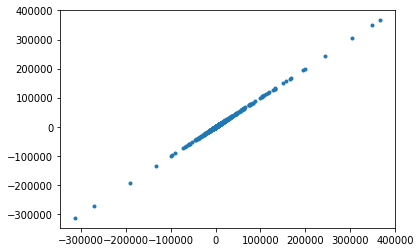

In [148]:
plt.plot(Y_train, Linear.predict(X_train), ls='', marker='.')

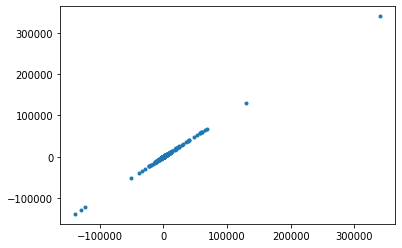

In [149]:
plt.plot(Y_test, Linear.predict(X_test), ls='', marker='.')

In [150]:
LinearRidge.fit(X_train, Y_train)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

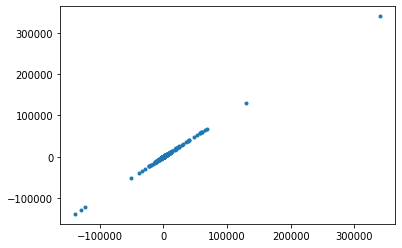

In [151]:
plt.plot(Y_test, LinearRidge.predict(X_test), ls='', marker='.')

In [152]:
RandomForest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

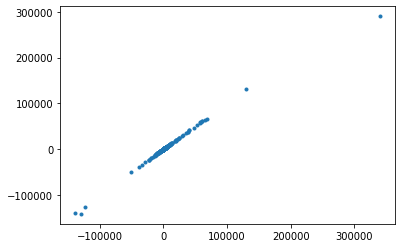

In [153]:
plt.plot(Y_test,RandomForest.predict(X_test), ls='', marker='.')

In [154]:
NeuralNetwork.fit(X_train,Y_train)

MLPRegressor(activation='relu', alpha=8, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(135, 135, 135), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

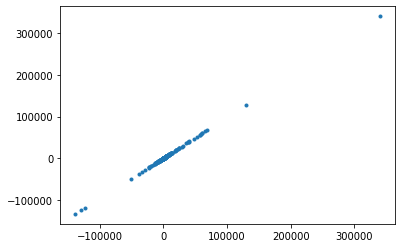

In [155]:
plt.plot(Y_test,NeuralNetwork.predict(X_test), ls='', marker='.')

In [156]:
enc.categories_

[array(['Butter', 'Cheese', 'Chiffon', 'Pound', 'Sponge', 'Tiramisu'],
       dtype=object),
 array(['Candy Outer', 'Chocolate Outer', 'Jelly Filled'], dtype=object),
 array(['Acai Berry', 'Amaretto', 'Apricot', 'Bavarian Cream',
        'Birch Beer', 'Black Licorice', 'Blueberry', 'Bourbon',
        'Butter Milk', 'Butter Pecan', 'Butter Toffee', 'Caramel Cream',
        'Cheesecake', 'Cherry Cola', 'Cherry Cream Spice', 'Chocolate',
        'Chocolate Mint', 'Coconut', 'Coffee', 'Cream Soda',
        'Creme de Menthe', 'Dill Pickle', 'Doughnut', 'Fruit Punch',
        'Ginger Ale', 'Ginger Beer', 'Ginger Lime', 'Gingersnap',
        'Grand Mariner', 'Horchata', 'Huckleberry', 'Irish Cream',
        'Kettle Corn', 'Lemon', 'Lemon Bar', 'Lemon Custard', 'Mango',
        'Margarita', 'Orange', 'Orange Brandy', 'Orange Pineapple\tP',
        'Pear', 'Pecan', 'Pink Lemonade', 'Plum', 'Raspberry Ginger Ale',
        'Sassafras', 'Sour', 'Spice', 'Toasted Coconut', 'Vanilla',
        'Water